#Initial Setup

In [1]:
import torch
import pandas as pd


import os
import io
import codecs
import joblib
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200) 
import string
import tensorflow as tf

from datetime import datetime
from tqdm import notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D


import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
#load data
df = pd.read_csv('/content/drive/MyDrive/Sample_COVID19_sentiments_interview.csv')

In [3]:
#preview
df.head()

,tweet_id,created_at,full_text,sentiment
0,0,2020-01-24 09:59:17+00:00,"RT @PravitR: There’s​ a derogatory saying that Chinese eats everything with four legs except table. After the Wuhan virus spread, South Chi…",Fear
1,1,2020-01-24 09:59:17+00:00,RT @ConflictsW: Reports that the Chinese Army (PLA) has been deployed in Wuhan to assist with the lockdown of the city\n#China #Wuhan #Coron…,Neutral
2,2,2020-01-24 09:59:17+00:00,RT @lokinhei: that is how authorities protect its own citizens. Not like Hong Kong.\n\nhttps://t.co/sWiS8fyubd,Anger
3,3,2020-01-24 09:59:18+00:00,Are u sharing ur expertise of what a failure leader is at the Forum? Or r u just spreeding the Wuhan coronavirus to the world? WTF u r doing when u should be dealing with Chinese coronavirus in ...,Fear
4,4,2020-01-24 09:59:19+00:00,"RT @Woppa1Woppa: Philippines is sending the Chinese back to Wuhan to prevent #coronavirus from spreading. Hey Carrie Lam, why don't you tr…",Fear


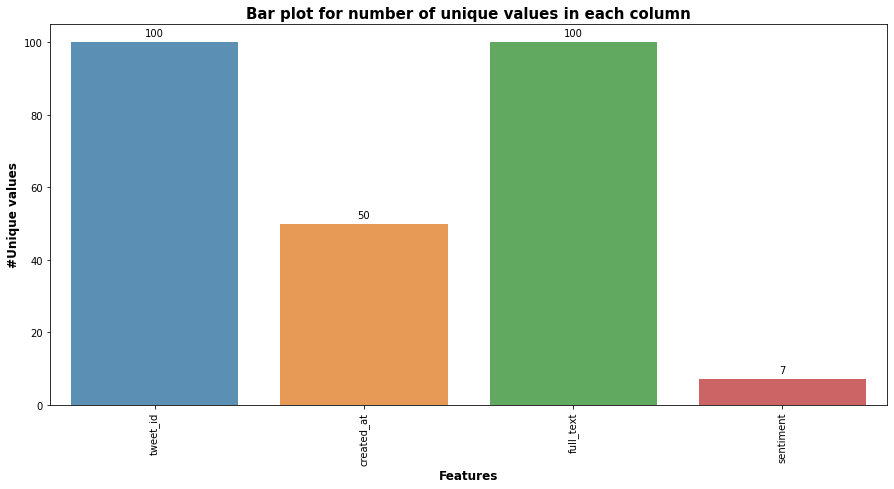

In [4]:
#Unique Values In Each Feature Coulmn

unique_df = pd.DataFrame()
unique_df['Features'] = df.columns
unique=[]
for i in df.columns:
    unique.append(df[i].nunique())
unique_df['Uniques'] = unique

f, ax = plt.subplots(1,1, figsize=(15,7))

splot = sns.barplot(x=unique_df['Features'], y=unique_df['Uniques'], alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Bar plot for number of unique values in each column',weight='bold', size=15)
plt.ylabel('#Unique values', size=12, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()

# Feature Set Generation

In [5]:
#Number of characters 
def count_chars(text):
    return len(text)
    print(text)

df['char_count'] = df["full_text"].apply(lambda x:count_chars(x))


In [6]:
  df['char_count']

0     140
1     140
2     108
3     290
4     140
     ... 
95    143
96    235
97    274
98    140
99    140
Name: char_count, Length: 100, dtype: int64

In [7]:
#Number of words
def count_words(text):
    return len(text.split())

df['word_count'] = df["full_text"].apply(lambda x:count_words(x))

In [8]:
df['word_count']

0     22
1     24
2     15
3     44
4     22
      ..
95    22
96    37
97    46
98    23
99    26
Name: word_count, Length: 100, dtype: int64

In [9]:
#Number of capital characters
def count_capital_chars(text):
    count=0
    for i in text:
        if i.isupper():
            count+=1
    return count

df['capital_char_count'] = df["full_text"].apply(lambda x:count_capital_chars(x))

In [10]:
#Number of capital words
def count_capital_words(text):
    return sum(map(str.isupper,text.split()))

df['capital_word_count'] = df["full_text"].apply(lambda x:count_capital_words(x))

In [11]:
#Count the number of punctuations
def count_punctuations(text):
    punctuations='!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~'
    d=dict()
    for i in punctuations:
        d[str(i)+' count']=text.count(i)
    return d 

df['punct_count'] = df["full_text"].apply(lambda x:count_punctuations(x))

In [12]:
#Number of words in quotes
def count_words_in_quotes(text):
    x = re.findall("'.'|\".\"", text)
    count=0
    if x is None:
        return 0
    else:
        for i in x:
            t=i[1:-1]
            count+=count_words(t)
        return count

df['quoted_word_count'] = df["full_text"].apply(lambda x:count_words_in_quotes(x))

In [13]:
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
#Number of sentences
def count_sent(text):
    return len(nltk.sent_tokenize(text))

df['sent_count'] = df["full_text"].apply(lambda x:count_sent(x))

In [15]:
#Count the number of unique words
def count_unique_words(text):
    return len(set(text.split()))

df['unique_word_count'] = df["full_text"].apply(lambda x:count_unique_words(x))

In [16]:
#Count of hashtags
def count_htags(text):
    x = re.findall(r'(#w[A-Za-z0-9]*)', text)
    return len(x) 

df['htag_count'] = df["full_text"].apply(lambda x:count_htags(x))

In [17]:
#Count of mentions
def count_mentions(text):
    x = re.findall(r'(@w[A-Za-z0-9]*)', text)
    return len(x)

df['mention_count'] = df["full_text"].apply(lambda x:count_mentions(x))

In [18]:
#Count of stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')

def count_stopwords(text):
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

df['stopword_count'] = df["full_text"].apply(lambda x:count_stopwords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
#Calculating average word length

df['avg_wordlength'] = df['char_count']/df['word_count']

In [20]:
#Calculating average sentence length

df['avg_sentlength'] = df['word_count']/df['sent_count']

In [21]:
#Unique words vs word count feature

df['unique_vs_words'] = df['unique_word_count']/df['word_count']

In [22]:
#Stopwords count vs words counts feature

df['stopwords_vs_words'] = df['stopword_count']/df['word_count']

In [23]:
df.columns

Index(['tweet_id', 'created_at', 'full_text', 'sentiment', 'char_count',
       'word_count', 'capital_char_count', 'capital_word_count', 'punct_count',
       'quoted_word_count', 'sent_count', 'unique_word_count', 'htag_count',
       'mention_count', 'stopword_count', 'avg_wordlength', 'avg_sentlength',
       'unique_vs_words', 'stopwords_vs_words'],
      dtype='object')

In [24]:
df['sentiment'].value_counts()

Neutral      48
Fear         33
Surprise      7
Sadness       4
Joy           3
Unrelated     3
Anger         2
Name: sentiment, dtype: int64

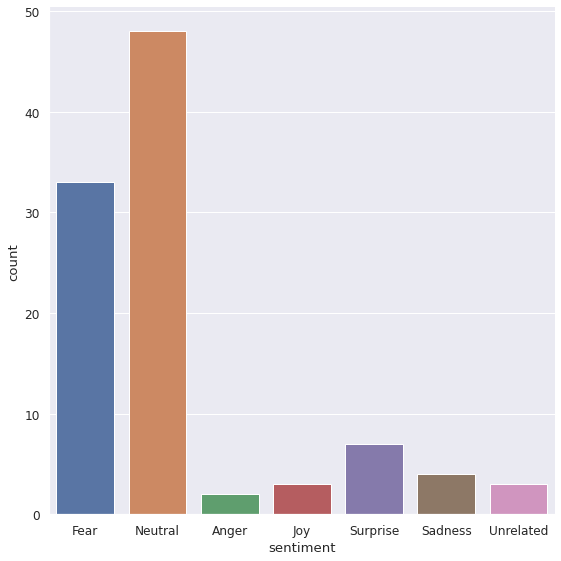

In [25]:
#top sentiments 

sns.set(font_scale=1.1)
sns.catplot("sentiment", data=df, kind="count", height=8)

# Data Preprocessing


In [26]:
#Removing @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

In [27]:
# create new column with removed @user
df['Tweet'] = np.vectorize(remove_pattern)(df['full_text'], '@[\w]*')

In [28]:
df.head(2)

,tweet_id,created_at,full_text,sentiment,char_count,word_count,capital_char_count,capital_word_count,punct_count,quoted_word_count,sent_count,unique_word_count,htag_count,mention_count,stopword_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words,Tweet
0,0,2020-01-24 09:59:17+00:00,"RT @PravitR: There’s​ a derogatory saying that Chinese eats everything with four legs except table. After the Wuhan virus spread, South Chi…",Fear,140,22,10,1,"{'! count': 0, '"" count': 0, '# count': 0, '$ count': 0, '% count': 0, '& count': 0, '' count': 0, '( count': 0, ') count': 0, '* count': 0, '+ count': 0, ', count': 1, '- count': 0, '. count': 1,...",0,2,22,0,0,4,6.363636,11.0,1.000000,0.181818,"RT : There’s​ a derogatory saying that Chinese eats everything with four legs except table. After the Wuhan virus spread, South Chi…"
1,1,2020-01-24 09:59:17+00:00,RT @ConflictsW: Reports that the Chinese Army (PLA) has been deployed in Wuhan to assist with the lockdown of the city\n#China #Wuhan #Coron…,Neutral,140,24,14,2,"{'! count': 0, '"" count': 0, '# count': 3, '$ count': 0, '% count': 0, '& count': 0, '' count': 0, '( count': 1, ') count': 1, '* count': 0, '+ count': 0, ', count': 0, '- count': 0, '. count': 0,...",0,1,22,0,0,10,5.833333,24.0,0.916667,0.416667,RT : Reports that the Chinese Army (PLA) has been deployed in Wuhan to assist with the lockdown of the city\n#China #Wuhan #Coron…


In [29]:
#REMOVED HTTP AND URLS FROM TWEET

import re
df['Tweet'] = df['Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [30]:
# remove special characters, numbers, punctuations
df['Tweet'] = df['Tweet'].str.replace('[^a-zA-Z#]+',' ')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            100 non-null    int64  
 1   created_at          100 non-null    object 
 2   full_text           100 non-null    object 
 3   sentiment           100 non-null    object 
 4   char_count          100 non-null    int64  
 5   word_count          100 non-null    int64  
 6   capital_char_count  100 non-null    int64  
 7   capital_word_count  100 non-null    int64  
 8   punct_count         100 non-null    object 
 9   quoted_word_count   100 non-null    int64  
 10  sent_count          100 non-null    int64  
 11  unique_word_count   100 non-null    int64  
 12  htag_count          100 non-null    int64  
 13  mention_count       100 non-null    int64  
 14  stopword_count      100 non-null    int64  
 15  avg_wordlength      100 non-null    float64
 16  avg_sentl

In [32]:
df.head()

,tweet_id,created_at,full_text,sentiment,char_count,word_count,capital_char_count,capital_word_count,punct_count,quoted_word_count,sent_count,unique_word_count,htag_count,mention_count,stopword_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words,Tweet
0,0,2020-01-24 09:59:17+00:00,"RT @PravitR: There’s​ a derogatory saying that Chinese eats everything with four legs except table. After the Wuhan virus spread, South Chi…",Fear,140,22,10,1,"{'! count': 0, '"" count': 0, '# count': 0, '$ count': 0, '% count': 0, '& count': 0, '' count': 0, '( count': 0, ') count': 0, '* count': 0, '+ count': 0, ', count': 1, '- count': 0, '. count': 1,...",0,2,22,0,0,4,6.363636,11.0,1.000000,0.181818,RT There s a derogatory saying that Chinese eats everything with four legs except table After the Wuhan virus spread South Chi
1,1,2020-01-24 09:59:17+00:00,RT @ConflictsW: Reports that the Chinese Army (PLA) has been deployed in Wuhan to assist with the lockdown of the city\n#China #Wuhan #Coron…,Neutral,140,24,14,2,"{'! count': 0, '"" count': 0, '# count': 3, '$ count': 0, '% count': 0, '& count': 0, '' count': 0, '( count': 1, ') count': 1, '* count': 0, '+ count': 0, ', count': 0, '- count': 0, '. count': 0,...",0,1,22,0,0,10,5.833333,24.0,0.916667,0.416667,RT Reports that the Chinese Army PLA has been deployed in Wuhan to assist with the lockdown of the city #China #Wuhan #Coron
2,2,2020-01-24 09:59:17+00:00,RT @lokinhei: that is how authorities protect its own citizens. Not like Hong Kong.\n\nhttps://t.co/sWiS8fyubd,Anger,108,15,7,1,"{'! count': 0, '"" count': 0, '# count': 0, '$ count': 0, '% count': 0, '& count': 0, '' count': 0, '( count': 0, ') count': 0, '* count': 0, '+ count': 0, ', count': 0, '- count': 0, '. count': 3,...",0,3,15,0,0,5,7.200000,5.0,1.000000,0.333333,RT that is how authorities protect its own citizens Not like Hong Kong
3,3,2020-01-24 09:59:18+00:00,Are u sharing ur expertise of what a failure leader is at the Forum? Or r u just spreeding the Wuhan coronavirus to the world? WTF u r doing when u should be dealing with Chinese coronavirus in ...,Fear,290,44,28,1,"{'! count': 0, '"" count': 0, '# count': 3, '$ count': 0, '% count': 0, '& count': 0, '' count': 0, '( count': 0, ') count': 0, '* count': 0, '+ count': 0, ', count': 0, '- count': 0, '. count': 2,...",0,4,37,0,0,16,6.590909,11.0,0.840909,0.363636,Are u sharing ur expertise of what a failure leader is at the Forum Or r u just spreeding the Wuhan coronavirus to the world WTF u r doing when u should be dealing with Chinese coronavirus in Hong...
4,4,2020-01-24 09:59:19+00:00,"RT @Woppa1Woppa: Philippines is sending the Chinese back to Wuhan to prevent #coronavirus from spreading. Hey Carrie Lam, why don't you tr…",Fear,140,22,10,1,"{'! count': 0, '"" count': 0, '# count': 1, '$ count': 0, '% count': 0, '& count': 0, '' count': 1, '( count': 0, ') count': 0, '* count': 0, '+ count': 0, ', count': 1, '- count': 0, '. count': 1,...",0,2,21,0,0,8,6.363636,11.0,0.954545,0.363636,RT Philippines is sending the Chinese back to Wuhan to prevent #coronavirus from spreading Hey Carrie Lam why don t you tr


In [33]:
#move to new dataframe
df_dataset = df[['Tweet','sentiment']]

In [34]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      100 non-null    object
 1   sentiment  100 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


In [35]:
#store classes into an array
possible_labels = df_dataset.sentiment.unique()
possible_labels

array(['Fear', 'Neutral', 'Anger', 'Joy', 'Surprise', 'Sadness',
       'Unrelated'], dtype=object)

In [36]:
#convert labels into numeric values
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [37]:
label_dict

{'Anger': 2,
 'Fear': 0,
 'Joy': 3,
 'Neutral': 1,
 'Sadness': 5,
 'Surprise': 4,
 'Unrelated': 6}

In [38]:
#convert labels into numeric values
df_dataset['label'] = df_dataset.sentiment.replace(label_dict)
df_dataset.head(10)

,Tweet,sentiment,label
0,RT There s a derogatory saying that Chinese eats everything with four legs except table After the Wuhan virus spread South Chi,Fear,0
1,RT Reports that the Chinese Army PLA has been deployed in Wuhan to assist with the lockdown of the city #China #Wuhan #Coron,Neutral,1
2,RT that is how authorities protect its own citizens Not like Hong Kong,Anger,2
3,Are u sharing ur expertise of what a failure leader is at the Forum Or r u just spreeding the Wuhan coronavirus to the world WTF u r doing when u should be dealing with Chinese coronavirus in Hong...,Fear,0
4,RT Philippines is sending the Chinese back to Wuhan to prevent #coronavirus from spreading Hey Carrie Lam why don t you tr,Fear,0
5,RT China built a lab to study SARS and Ebola in Wuhan and US biosafety experts warned in that a virus could escape th,Neutral,1
6,RT A year old woman is the first Thai to test positive for coronavirus The patient fell ill shortly after returning fro,Neutral,1
7,RT Singapore confirms first case of Wuhan virus,Neutral,1
8,RT Video In Wuhan where the outbreak began anxiety and anger prevailed as worried residents crowded into hospitals and teams o,Neutral,1
9,RT Should we be worried about coronavirus in #Thailand Yes and no The chance of people getting the virus is low Even tho,Fear,0


In [39]:
df_dataset.drop(['sentiment'], axis=1, inplace=True)

In [40]:
df_dataset.head()

,Tweet,label
0,RT There s a derogatory saying that Chinese eats everything with four legs except table After the Wuhan virus spread South Chi,0
1,RT Reports that the Chinese Army PLA has been deployed in Wuhan to assist with the lockdown of the city #China #Wuhan #Coron,1
2,RT that is how authorities protect its own citizens Not like Hong Kong,2
3,Are u sharing ur expertise of what a failure leader is at the Forum Or r u just spreeding the Wuhan coronavirus to the world WTF u r doing when u should be dealing with Chinese coronavirus in Hong...,0
4,RT Philippines is sending the Chinese back to Wuhan to prevent #coronavirus from spreading Hey Carrie Lam why don t you tr,0


#Load Fasttext vectors


In [41]:
#!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
#!gzip -d cc.en.300.vec.gz

In [42]:
#create word vectors
from tqdm import tqdm_notebook

word_vectors = {}
f = io.open("/content/cc.en.300.vec", encoding='utf-8')
n, d = map(int, f.readline().split())
for line in tqdm_notebook(f):
    values = line.rstrip().split(' ')
    word = values[0]
    vector = np.array(values[1:], dtype='float32')
    word_vectors[word] = vector
f.close()
print(f'found {len(word_vectors)} word vectors')

0it [00:00, ?it/s]

found 2000000 word vectors


# Text length distribution

In [43]:
#Finding the text length distribution
df_dataset['sent_len'] = df_dataset['Tweet'].apply(lambda x: len(x.split(" ")))
max_seq_len = np.round(df_dataset['sent_len'].mean() + 2 * df_dataset['sent_len'].std()).astype(int)
max_seq_len

39

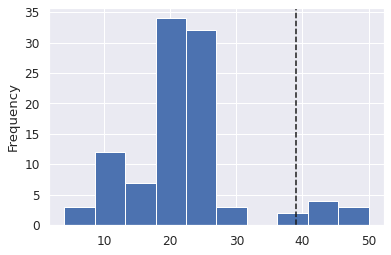

In [44]:
df_dataset['sent_len'].plot.hist()
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len');

# Clean

In [45]:
df_dataset.head()

,Tweet,label,sent_len
0,RT There s a derogatory saying that Chinese eats everything with four legs except table After the Wuhan virus spread South Chi,0,23
1,RT Reports that the Chinese Army PLA has been deployed in Wuhan to assist with the lockdown of the city #China #Wuhan #Coron,1,24
2,RT that is how authorities protect its own citizens Not like Hong Kong,2,14
3,Are u sharing ur expertise of what a failure leader is at the Forum Or r u just spreeding the Wuhan coronavirus to the world WTF u r doing when u should be dealing with Chinese coronavirus in Hong...,0,44
4,RT Philippines is sending the Chinese back to Wuhan to prevent #coronavirus from spreading Hey Carrie Lam why don t you tr,0,23


In [46]:
regex_tokenizer = RegexpTokenizer(r'\w+')

In [47]:
cleaned_text = []

for text in tqdm_notebook(df_dataset['Tweet']):
    tokens = regex_tokenizer.tokenize(text)
    cleaned_text.append(" ".join(tokens))

  0%|          | 0/100 [00:00<?, ?it/s]

In [48]:
print(cleaned_text[0])

RT There s a derogatory saying that Chinese eats everything with four legs except table After the Wuhan virus spread South Chi


#Tokenize

In [49]:
max_words = 1e5

In [50]:
tokenizer = Tokenizer(num_words=max_words, lower=True, char_level=False)

In [51]:
#tokenize and build dictionary
tokenizer.fit_on_texts(cleaned_text)
input_sequences = tokenizer.texts_to_sequences(cleaned_text)

word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

dictionary size:  793


In [52]:
print(input_sequences[0])

[3, 49, 13, 5, 252, 129, 28, 12, 253, 130, 21, 254, 255, 91, 256, 92, 1, 2, 15, 36, 257, 131]


# Padding

In [53]:
#pad text to make it of equal length
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len)

In [54]:
print(input_sequences[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   3
  49  13   5 252 129  28  12 253 130  21 254 255  91 256  92   1   2  15
  36 257 131]


In [55]:
labels = df_dataset['label'].values

In [56]:
print(labels[36])

4


#Embedding matrix

In [57]:
embed_dim = 300

In [58]:
#creating the embedding matrix
words_not_found = []
nb_words = min(max_words, len(word_index))

embedding_matrix = np.zeros((nb_words+1, embed_dim))

for word, i in word_index.items():
    if i > nb_words:
        break

    vector = word_vectors.get(word)
    if vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = vector
    else:
        words_not_found.append(word)

print('number of null word embeddings: {:d}'.format(np.sum(np.sum(embedding_matrix, axis=1) == 0)))

number of null word embeddings: 35


In [59]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['quaranted' 'quaranted' 'serginho' 'wuhanoutbre' 'wuhancoronavirus'
 'serginho' 'turkistan' 'disposabl' 'blackpink' 'hankou']


#Train Test Split

In [60]:
#splitting the given dataset into train and test sets
X_train, X_test, y_train, y_test = (
    train_test_split(input_sequences, labels, random_state=42, test_size=0.2)
)

In [61]:
X_train = tf.constant(X_train)
X_test = tf.constant(X_test)

y_train = tf.constant(y_train)
y_test = tf.constant(y_test)

In [62]:
print(f'Train | X shape: {X_train.shape}, y shape: {y_train.shape}')
print(f'Test | X shape: {X_test.shape}, y shape: {y_test.shape}')

Train | X shape: (80, 39), y shape: (80,)
Test | X shape: (20, 39), y shape: (20,)


# Create model

In [63]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [64]:
#defining the model
def create_model(input_len):
    inp = Input(shape=(input_len,))

    x = Embedding(nb_words+1, embed_dim,
                  weights=[embedding_matrix],
                  input_length=input_len, trainable=False)(inp)
    
    x1 = Conv1D(200, 3, activation='relu', padding='same')(x)
    x1 = GlobalMaxPooling1D()(x1)

    x2 = Conv1D(200, 4, activation='relu', padding='same')(x)
    x2 = GlobalMaxPooling1D()(x2)

    x3 = Conv1D(200, 5, activation='relu', padding='same')(x)
    x3 = GlobalMaxPooling1D()(x3)

    x = concatenate([x1, x2, x3])
    x = Dropout(0.5)(x)
    x = Dense(30, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(7, activation='softmax')(x)

    model = Model(inputs=inp, outputs=x)

    opt = tf.keras.optimizers.Adam(lr=0.001)

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy',f1_m,precision_m, recall_m])

    return model

In [65]:
model = create_model(max_seq_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 39)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 39, 300)      238200      ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 39, 200)      180200      ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 39, 200)      240200      ['embedding[0][0]']              
                                                                                              

# Training

In [66]:
#metrics for evaluation
loss, metric, f1, prec, rec = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
print(f"Loss before training: {loss:.4f} \nAccuracy before training: {metric:.2%} \nF1 Score: {f1:.4f} \nPrecision: {prec:.4f} \nRecall: {rec:.4f}")

Loss before training: 2.1931 
Accuracy before training: 0.00% 
F1 Score: 0.1538 
Precision: 10000000.0000 
Recall: 0.0769


In [67]:
df_dataset.dtypes

Tweet       object
label        int64
sent_len     int64
dtype: object

In [68]:
#fitting the model
history = model.fit(X_train, y_train, batch_size=256, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
1/1 [==============================] - 1s 1s/step - loss: 2.2980 - accuracy: 0.0750 - f1_m: 2.5172 - precision_m: 18.2500 - recall_m: 1.3519 - val_loss: 1.7698 - val_accuracy: 0.5000 - val_f1_m: 0.1538 - val_precision_m: 10000000.0000 - val_recall_m: 0.0769
Epoch 2/5
1/1 [==============================] - 0s 255ms/step - loss: 1.8583 - accuracy: 0.2250 - f1_m: 2.5926 - precision_m: 700000000.0000 - recall_m: 1.2963 - val_loss: 1.5416 - val_accuracy: 0.6000 - val_f1_m: 0.1538 - val_precision_m: 10000000.0000 - val_recall_m: 0.0769
Epoch 3/5
1/1 [==============================] - 0s 269ms/step - loss: 1.6090 - accuracy: 0.4375 - f1_m: 2.7719 - precision_m: 26.3333 - recall_m: 1.4630 - val_loss: 1.3796 - val_accuracy: 0.6000 - val_f1_m: 0.1538 - val_precision_m: 10000000.0000 - val_recall_m: 0.0769
Epoch 4/5
1/1 [==============================] - 0s 242ms/step - loss: 1.6847 - accuracy: 0.3375 - f1_m: 2.2857 - precision_m: 8.0000 - recall_m: 1.3333 - val_loss: 1.2760 - val_accur

In [69]:
# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])


In [70]:
# evaluate the model
#loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)
loss, metric, f1, prec, rec = model.evaluate(X_test, y_test, batch_size=32, verbose=0)

In [71]:
print(f"Loss after training: {loss:.4f} \nAccuracy after training: {metric:.2%} \nF1 Score : {f1:.4f} \nPrecision: {prec:.4f} \nRecall: {rec:.4f}")

Loss after training: 1.2009 
Accuracy after training: 60.00% 
F1 Score : 0.5000 
Precision: 1.3333 
Recall: 0.3077


# Test model on new sentences

In [72]:
def predict(text):
  # pre-process text
    tokens = regex_tokenizer.tokenize(text)
    cleaned_text = [" ".join(tokens)]
    
    input_ = tokenizer.texts_to_sequences(cleaned_text)
    input_ = pad_sequences(input_, maxlen=max_seq_len)
    
    pred = model.predict(input_)[0]

    return pred

In [73]:
label_dict

{'Anger': 2,
 'Fear': 0,
 'Joy': 3,
 'Neutral': 1,
 'Sadness': 5,
 'Surprise': 4,
 'Unrelated': 6}

In [74]:
text = "i am afraid of the virus"

In [75]:
predict(text)

array([0.2648982 , 0.30254954, 0.0486162 , 0.05385831, 0.1540297 ,
       0.09268133, 0.08336673], dtype=float32)

In [76]:
result = np.argmax(predict(text), axis=0)
print("Sentiment : ",list(label_dict.keys())[list(label_dict.values()).index(result)])

Sentiment :  Neutral


In [77]:
text = "I dont care about the virus"

In [78]:
predict(text)

array([0.2338636 , 0.25274068, 0.0710441 , 0.06746957, 0.164423  ,
       0.11328064, 0.0971784 ], dtype=float32)

In [79]:
result = np.argmax(predict(text), axis=0)
print("Sentiment : ",list(label_dict.keys())[list(label_dict.values()).index(result)])

Sentiment :  Neutral


#Save model

In [80]:
model_save_path = "model.h5"
model.save(model_save_path)

In [81]:
tokenizer_save_path = "tokenizer.joblib"
joblib.dump(tokenizer, tokenizer_save_path)

['tokenizer.joblib']